In this file I prepare code for undersampling AF2 for actual k-space data (Rings); this will have to be transferred to matlab code.

**Strategy**

The strategy is as follows, I keep 15% of k-space data in the center of k-space (no undersampling, highest signal region).

Then I randomly delete k_z planes (except for the 20%) until I have a ~50% of data in k-space. For the next time step I do the same
but with the restriction that I take different random planes, to get a complementary pattern, etc.

In [1]:
import sys
import os

sys.path.append('../../../scripts')
sys.path.append('../../../models')

import copy
os.environ["CUDA_VISIBLE_DEVICES"]= '2' #, this way I would choose GPU 3 to do the work

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import time
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from scipy.fft import fft2, fftshift
from scipy.io import loadmat
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from scipy.io import loadmat
import random

from data_preparation import *
import plotly.graph_objects as gorings
import scipy.io as sio

In the code below, I compute exactly how much percent of k-space is sampled at which k_z position

No handles with labels found to put in legend.


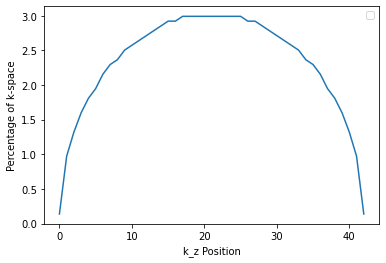

In [2]:
mat_data_8 = loadmat('../../fn_vb_DMI_CRT_P04/CombinedCSI_full_rank.mat')
csi_data = mat_data_8['csi']
Data = csi_data['Data'][0,0]

Par = csi_data['Par'][0,0]

Circles_Per_kz_Matrix = Par['AngIntsPerPartEnc'][0,0]

Circles_Per_kz = np.zeros(43)

for i in range(0,43):
    Circles_Per_kz[i] = np.sum(Circles_Per_kz_Matrix[i])

Percentage_Per_kz = 100*Circles_Per_kz / np.sum(Circles_Per_kz)

plt.plot(Percentage_Per_kz)

# Add labels and title
plt.xlabel("k_z Position")
plt.ylabel("Percentage of k-space")

# Add a legend
plt.legend()

# Show the plot
plt.show()

Compute how many central planes amount to ~20% of the data

In [3]:
x = 0
x = x + Percentage_Per_kz[21]
for i in range(1,3):
    x = x + Percentage_Per_kz[21-i]+Percentage_Per_kz[21+i]
    print(21-i)
    print(21+i)
    
print(x)

20
22
19
23
14.961725817675713


In [4]:
#### Next I want to undersample in a complementary fashion. I generate a pool that has all indices that are not sampled 
#### except for ones that are always kept across time steps. 

def pool(kept_Indices, Number_Circles):
    all_indices = np.arange(Number_Circles)  # Generate array [0, 1, ..., Number_Circles-1]
    return np.delete(all_indices, kept_Indices)  # Remove indices in kept_Indices

In [5]:
kspace_percentage = Percentage_Per_kz

# fixed_kz_indices = list(range(19, 24)) ## this is always sampled

# target_percentage = 25

# #### Pool keeps track of which k_z indices have already been sampled; it contains the UNSAMPLED indices
# Pool = pool(fixed_kz_indices, 43)

# Pool_fixed = pool(fixed_kz_indices, 43) # this second pool never shrinks. If at a certain timesteps
# # it is not managed to draw from the normal Pool anymore (because percentage contributions are too high)
# #its still allowed to make 20 attempts from the fixed pool, to be able to sample even more



# ## make sure you cannot have more than 100 attempts to select planes
# dummy = 0 
# covered_percentage =  np.sum(kspace_percentage[fixed_kz_indices])   # ~29%

# Mask_kz_T = np.zeros((43,8))
# Extra_Attempt = 0## allow up to 20 times to sample even closer to desired AF  
# for T in range(0,8):
#     temp_mask = np.zeros_like(kspace_percentage, dtype=int)  ## 0 to 42, one index per k_z position
#     temp_mask[fixed_kz_indices] = 1  # always include fixed planes
    
#     dummy = 0
#     covered_percentage =  np.sum(kspace_percentage[fixed_kz_indices])   # ~29%
#     while dummy < 1000:
#         dummy = dummy +1
#         Extra_Attempt = 0

#         if len(Pool) == 0: # pool is refreshed if it is empty
#             Pool = pool(fixed_kz_indices, 43)

#         kept_index = random.randint(0, len(Pool)-1)  # randomly select k_z position to keep
#         additional_coverage = kspace_percentage[Pool[kept_index]] # this is how much percent of kspace this position covers
       
        
#         if covered_percentage + additional_coverage < target_percentage:
#             temp_mask[Pool[kept_index]] = 1
#             Pool = np.delete(Pool,kept_index)
#             covered_percentage = covered_percentage + additional_coverage
#         else:
#             while Extra_Attempt <10: # try to draw from fixed pool
#                 kept_index = random.randint(0, len(Pool_fixed)-1)
#                 additional_coverage = kspace_percentage[Pool_fixed[kept_index]]

#                 Extra_Attempt = Extra_Attempt +1

#                 if covered_percentage + additional_coverage < target_percentage and temp_mask[Pool_fixed[kept_index]] == 0:
#                     temp_mask[Pool_fixed[kept_index]] = 1
#                     covered_percentage = covered_percentage + additional_coverage

            
#     Mask_kz_T[:,T] = temp_mask

# for T in range(0,8):
#     print(np.sum(Mask_kz_T[:,T]*kspace_percentage))
    
# for T in range(0,8):
#     print(f'Sampled k_z Positions time step {T+1}:')
#     print(np.where(Mask_kz_T[:,T])[0])
    
# file_name = "Sampling_Patterns_Regular/Mask_AF4.npy"    

# # # Check if the file exists
# if os.path.exists(file_name):
#      print(f"File '{file_name}' already exists. Skipping save.")
        
# else:
# #     # Save the Mask array to .mat
#     np.save(file_name, Mask_kz_T)
#     print(f"File '{file_name}' saved successfully.")

Mask_kz_T = np.load("Sampling_Patterns_Regular/Mask_AF4.npy")

Mask_kz_T_Test = np.zeros((43))
for i in range(0,8):
    Mask_kz_T_Test = Mask_kz_T_Test + Mask_kz_T[:,i]
    
print(Mask_kz_T_Test)  ### if there are no 0s it means everything was sampled at least once


np.where(Mask_kz_T_Test == 0)[0]
kspace_percentage[np.where(Mask_kz_T_Test == 0)[0]]
print("Total percent sampled over time:")
print(100-np.sum(kspace_percentage[np.where(Mask_kz_T_Test == 0)[0]]))

[7. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 8. 8. 8. 8. 8.
 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 2. 1. 1. 1. 0. 1. 2. 8.]
Total percent sampled over time:
84.69032707028532


**Reshaping**

The above code accomplishes that I have the complete k_space mask information in the format (k_z, T). If Mask[i,j] = 1, it means k_z position can be sampled at timestep T, otherwise not. However, in Matlab the data is saved is saved as csi.Data with the following format:

size(csi.Data) = 1 43; a list of 43 entries, one for each RING. Then size(csi.Data{i}) = 526 1 N 1 96 1 8; where N is the number of k_z partitions this ring appears in. Unfortunately, N is not directly the k_z index, but rather N = 1 corresponds to the smallest k_z index that has been measured etc. So what I want is this:

**Goal:**

I create a dictionary structure "ring_sampling" that mirrors the matlabl structure. So ring_sampling[i] is a list of list for ring i.
The outer list has 8 elements, for the 8 time steps, then each of these 8 inner lists has the indices that should be sampled.

**First step**

Create a matrix with the matlab indices for each Ring. I accomplish this by using the matrix Circles_Per_kz_Matrix which is 1 at index i,j if the ith kz position was measured by ring j, and 0 else. I multiply this matrix by a matrix of shape 43x43 point wise (same shape) which has 1 in the first row 2 in the second row etc. It is important to note that the k_z positions are counted beginning from 1 not 0.

In [6]:
Circles_Per_kz_Matrix[0,0]

# Create a column vector of row numbers (starting from 1)
n=43
row_numbers = np.arange(1, n + 1).reshape(n, 1)
matrix = np.tile(row_numbers, (1, n))
matrix_inverse = 1 / matrix

Sampled_Indices_Per_Ring = matrix * Circles_Per_kz_Matrix

print(Sampled_Indices_Per_Ring[:,42])

#Sampled_Indices_Per_Ring: This means e.g. Sampled_Indices_Per_Ring[:,0] gives all the k_z indizes (sstartng from 1 not 0 (!)) that have been sampled by Ring 0 etc.

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 18 19 20 21 22 23 24
 25 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In here I save the minimum k_z positions that has been sampled per ring, again this starts at k_z = 0

In [7]:
Minimum_kz_position = np.zeros(43)

for i in range(0,43):
    Sampled_kz_ring_i = Sampled_Indices_Per_Ring[:,i]
    first_nonzero = next((x for x in Sampled_kz_ring_i if x != 0), None)
    Minimum_kz_position[i] = first_nonzero -1 #start at 0 not at 1

In [8]:
Minimum_kz_position

array([ 0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,
        5.,  5.,  6.,  6.,  6.,  7.,  7.,  8.,  9.,  9., 10., 11., 12.,
       13., 14., 15., 17.])

# ***Creating apropritate data structure***

Now I want to start to assemble which rings have actually been sampled. First I create a dictionary, containing 43 elements (rings) each containing a list of list (upper list 8 time steps, and then a list for what has been sampled at that time step by that ring). This is the format in which it is saved in matlab.

In [9]:
num_rings = 43
num_time_steps = 8

# Create a dictionary to hold the sampling info for each ring.
# Keys are ring numbers (here, 0-indexed; you can adjust to 1-indexed if you prefer).
# Each value is a list of length num_time_steps, where each element is a list of indices
# for that ring that are sampled at that time step.
ring_sampling = {}

for ring in range(num_rings):
    # For each ring, initialize an empty list for each time step.
    ring_sampling[ring] = [[] for _ in range(num_time_steps)]

# Example: suppose for ring 0 at time step 0 we sampled indices [1, 3, 5]
#ring_sampling[0][0] = [1, 3, 5]

# And perhaps for ring 0 at time step 1 we sampled indices [2, 4]
#ring_sampling[0][1] = [2, 4]

#ring_sampling

Next, I actually save something to that structure. I start with the fully sampled case.

In [10]:
for ring in range(0,43):
    for T in range(0,8):
        ring_sampling[ring][T] = np.array([x for x in Sampled_Indices_Per_Ring[:,ring] if x !=0]).reshape(-1)

ring_undersampling = copy.deepcopy(ring_sampling)

In [11]:
ring_sampling[2][0]

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42])

# ***Undersampling***

Now the above dictionary has the complete information from the fully sampled case. Now I want to apply undersampling, by combining my knowledge of Mask_kz_T with the above case. All k_z indices not appearing in the mask are simply deleted.

In [12]:
for ring in range(0,43):
    for T in range(0,8):
        ### delete everything that has not been sampled
        for kz in range(0,len(Mask_kz_T[:,T])):
            if  Mask_kz_T[kz,T] == 0:
                deleted_kz = kz +1 ### note that in the ring structure the kz indices started at 1
                ring_undersampling[ring][T] = ring_undersampling[ring][T][ring_undersampling[ring][T] != deleted_kz]

# ***Final conversion***

Here, I finally convert this to the format saved in matlab, where within each ring, index 1 refers to the smallest measured k_z position for that ring etc. I do this by subtracting the minimum k_z position saved earlier

In [13]:
ring_undersampling_final_format = copy.deepcopy(ring_undersampling)

for ring in range(0,43):
    for T in range(0,8):
        ring_undersampling_final_format[ring][T] = ring_undersampling_final_format[ring][T] - (np.ones((len(ring_undersampling_final_format[ring][T])))*Minimum_kz_position[ring])

In [14]:
ring_undersampling_final_format[0]

[array([ 8.,  9., 20., 21., 22., 23., 24., 29., 36., 43.]),
 array([ 1.,  4., 13., 20., 21., 22., 23., 24., 33., 36., 43.]),
 array([ 1.,  7., 15., 20., 21., 22., 23., 24., 31., 38., 43.]),
 array([ 1.,  5., 11., 18., 20., 21., 22., 23., 24., 37., 43.]),
 array([ 1.,  4.,  6., 20., 21., 22., 23., 24., 25., 34., 43.]),
 array([ 1.,  2., 17., 20., 21., 22., 23., 24., 27., 41., 42., 43.]),
 array([ 1.,  3., 12., 14., 19., 20., 21., 22., 23., 24., 43.]),
 array([ 1.,  3., 10., 20., 21., 22., 23., 24., 28., 39., 42., 43.])]

# ***Save to matlab file and numpy array***

In [15]:
num_rings = 43

# Assuming ring_undersampling_final_format is a dictionary with keys 0, 1, ..., 42,
# where each ring_undersampling_final_format[ring] is a list (of 8 time steps) containing the sampled indices for that ring.
# Create an empty NumPy object array with shape (1, num_rings)
data_array = np.empty((1, num_rings), dtype=object)

# Fill the array with your data from each ring
for ring in range(num_rings):
    data_array[0, ring] = ring_undersampling_final_format[ring]

# Create a structure similar to your MATLAB structure, e.g., csi.Data
csiUndersampled = {'Data': data_array}

# Save the structure to a .mat file
sio.savemat('csiUndersampled_AF4.mat', {'csiUS': csiUndersampled})

/opt/conda/lib/python3.7/site-packages/scipy/io/matlab/mio5.py:450: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


# ***visualize undersampling pattern***

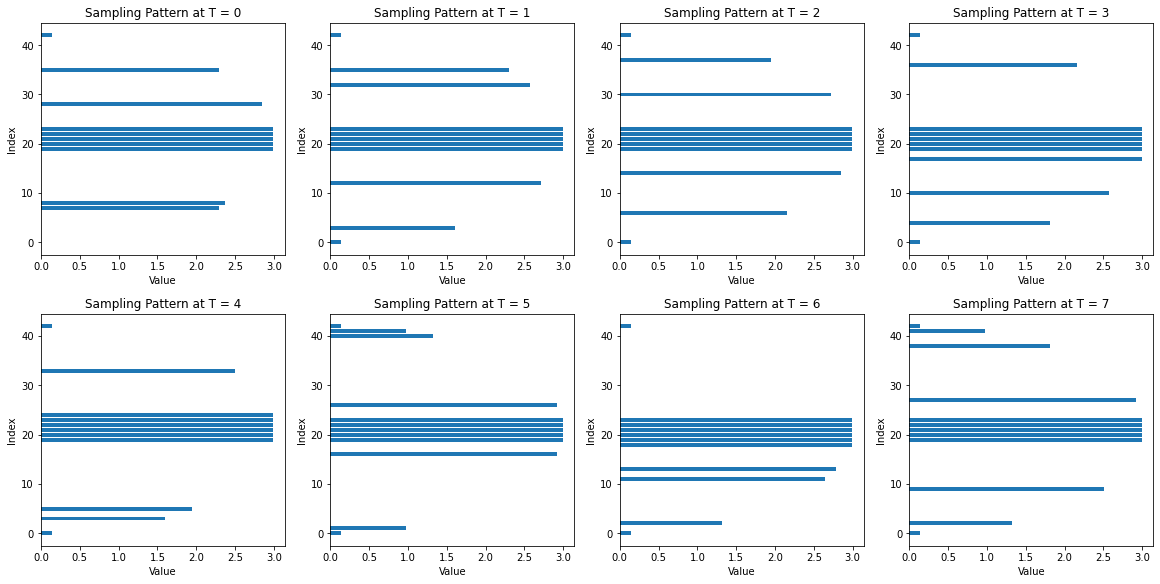

In [16]:
kspace_percentage

# X-Achse (Index der Einträge)


fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)

# Plot each subplot
for i, ax in enumerate(axes.flat):
    y = np.arange(len(kspace_percentage))  # Index positions for the bars
    ax.barh(y, kspace_percentage*Mask_kz_T[:,i])  # Create horizontal bar chart
    ax.set_title(f"Sampling Pattern at T = {i}")  # Set title for each subplot
    ax.set_ylabel("Index")
    ax.set_xlabel("Value")

# Show the plot
plt.show()

# Diagramm anzeigen
plt.show()

In [17]:
csiUndersampled['Data'][0,20][2]

array([ 4., 12., 17., 18., 19., 20., 21., 28., 35.])

**Reconstruction k-z Positions of Rings**

In [18]:
mat_data_4 = loadmat('../../fn_vb_DMI_CRT_P04/CombinedCSI_full_rank.mat')
csi_data = mat_data_4['csi']
par_data = csi_data['Par'][0,0]
Data_Size = par_data['DataSize'][0][0][0]
Data_Size

array([array([[526,   1,  43,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  43,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  39,   1,  96,   1,   8]], dtype=uint

In [19]:
Number_Of_Rings = 0
for i in range(0,43):
    Number_Of_Rings = Number_Of_Rings +Data_Size[i][0][2]
print('Total Number of Rings')
print(Number_Of_Rings)

print('Total Number of k-Space points')
print(Number_Of_Rings*526)

Total Number of Rings
1437
Total Number of k-Space points
755862


In [20]:
43*4

172

In [21]:
172/(1437)

0.11969380654140571